In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
import astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import (ImageNormalize, AsinhStretch,
                                    LinearStretch)
import astropy.constants as const
import astropy.units as u
from astropy.time import Time
from scipy.io import readsav
import sunpy
import sunpy.map
from sjireader import read_iris_sji
import cmcrameri.cm as cmcm
from sunkit_image import coalignment
from sun_blinker import SunBlinker
import iris_spec_recon
import importlib
importlib.reload(iris_spec_recon)
from iris_spec_recon import iris_spec_map_interp_from_header

In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1),orientation="vertical"):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [3]:
SiIV_1393_fitres_file = readsav("../../src/IRIS/20221024/2322/fit_res/SiIV_1393_raster0.sav",verbose=True)

--------------------------------------------------
Date: Thu Feb 15 09:12:15 2024
User: yjzhu
Host: NB-RES-YINGJIE
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.8.3
--------------------------------------------------
Successfully read 12 records of which:
 - 9 are of type VARIABLE
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - int [<class 'numpy.ndarray'>]
 - int_err [<class 'numpy.ndarray'>]
 - vel [<class 'numpy.ndarray'>]
 - vel_err [<class 'numpy.ndarray'>]
 - wid [<class 'numpy.ndarray'>]
 - wid_err [<class 'numpy.ndarray'>]
 - chi2 [<class 'numpy.ndarray'>]
 - refwvl [<class 'numpy.ndarray'>]
 - wave_corr_fuv [<class 'numpy.ndarray'>]
--------------------------------------------------


In [4]:
SiIV_1393_fitres_file["refwvl"]

array([1393.75500488], dtype='>f8')

In [5]:
raster_header_0 = fits.getheader("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",ext=0)
raster_header_SiIV = fits.getheader("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",ext=3)
raster_header_CII = fits.getheader("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",ext=1)
raster_header_MgII = fits.getheader("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",ext=6)

In [6]:
SiIV_1393_fitres_file["wid"].shape

(548, 320)

In [7]:
SiIV_1393_mask = (np.abs(SiIV_1393_fitres_file["wid_err"]/SiIV_1393_fitres_file["wid"]) > 0.5) | \
                (SiIV_1393_fitres_file["wid"] < 0.04) | \
                (np.abs(SiIV_1393_fitres_file["int_err"]/SiIV_1393_fitres_file["int"]) > 0.5) | \
                (np.abs(SiIV_1393_fitres_file["vel_err"]) > 10 )


In [8]:
SiIV_1393_int_map = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                    win_ext=3,data=SiIV_1393_fitres_file["int"].copy())
SiIV_1393_int_map.plot_settings["cmap"] = "irissji1400"
SiIV_1393_int_map.plot_settings["norm"] = ImageNormalize(vmin=0,vmax=1e4,stretch=AsinhStretch(0.1))
SiIV_1393_int_map.meta["rsun_ref"] = 696000000.0

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


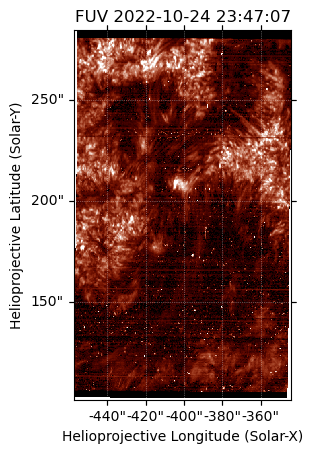

In [9]:
SiIV_1393_int_map.plot()

In [10]:
SiIV_1393_vel_map = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                    win_ext=3,data=SiIV_1393_fitres_file["vel"] + SiIV_1393_fitres_file["wave_corr_fuv"][np.newaxis,:]/1393.755*const.c.to_value(u.km/u.s),
                    mask=SiIV_1393_mask)
SiIV_1393_vel_map.plot_settings["cmap"] = "RdBu_r"
SiIV_1393_vel_map.plot_settings["norm"] = ImageNormalize(vmin=-30,vmax=30)
SiIV_1393_vel_map.meta["rsun_ref"] = 696000000.0

In [11]:
SiIV_1393_veff = np.sqrt(SiIV_1393_fitres_file["wid"]**2 - (25.85e-3)**2)/1393.755/np.sqrt(4*np.log(2))*const.c.to_value(u.km/u.s)
SiIV_1393_vth2 = np.sqrt(2*const.k_B*10**4.9*u.K/const.u/28.0855).to_value(u.km/u.s)
SiIV_1393_vnth = np.sqrt(SiIV_1393_veff**2 - SiIV_1393_vth2**2)
SiIV_1393_vnth_map = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                    win_ext=3,data=SiIV_1393_vnth,
                    mask=SiIV_1393_mask)
SiIV_1393_vnth_map.plot_settings["cmap"] = cmcm.batlowK
SiIV_1393_vnth_map.plot_settings["norm"] = ImageNormalize(vmin=10,vmax=35)
SiIV_1393_vnth_map.meta["rsun_ref"] = 696000000.0

/tmp/ipykernel_663834/3880291802.py:3: RuntimeWarning: invalid value encountered in sqrt
  SiIV_1393_vnth = np.sqrt(SiIV_1393_veff**2 - SiIV_1393_vth2**2)


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


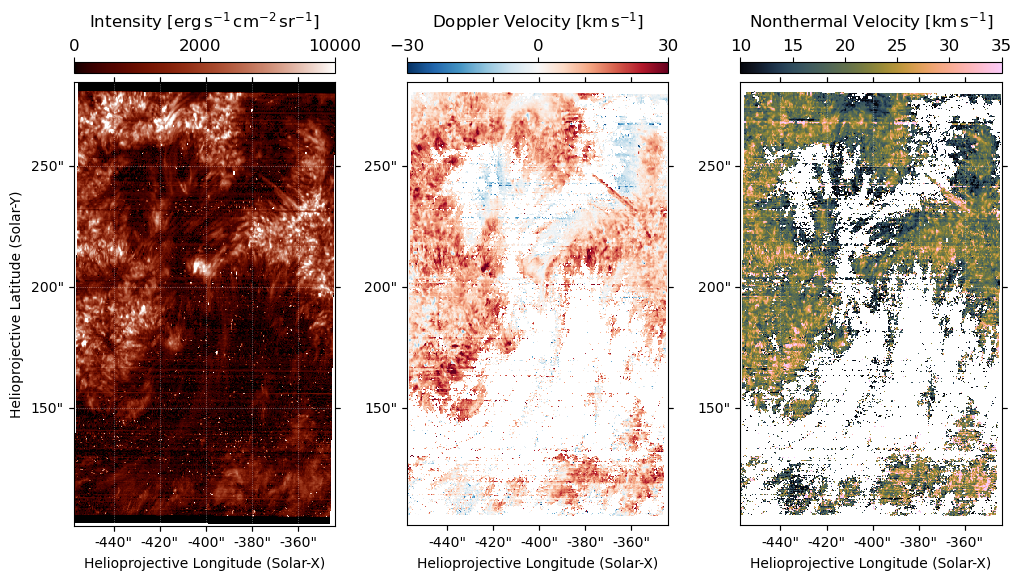

In [12]:
fig = plt.figure(figsize=(10,8),layout="constrained")

ax1 = fig.add_subplot(131,projection=SiIV_1393_int_map)
im1 = SiIV_1393_int_map.plot(axes=ax1)
clb1, clb_ax1 = plot_colorbar(im1,ax1,width="100%",height="8%",fontsize=12,
              bbox_to_anchor=(0,1.02,1,0.3),
              orientation="horizontal")
clb_ax1.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax1.set_xticks([0,2000,10000])
ax1.set_title(r"Intensity [$\rm erg\,s^{-1}\,cm^{-2}\,sr^{-1}$]",fontsize=12,pad=40)


ax2 = fig.add_subplot(132,projection=SiIV_1393_vel_map)
im2 = SiIV_1393_vel_map.plot(axes=ax2)
clb2, clb_ax2 = plot_colorbar(im2,ax2,width="100%",height="8%",fontsize=12,
              bbox_to_anchor=(0,1.02,1,0.3),
              orientation="horizontal")
clb_ax2.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax2.set_xticks([-30,0,30])
ax2.set_title(r"Doppler Velocity [$\rm km\,s^{-1}$]",fontsize=12,pad=40)

ax3 = fig.add_subplot(133,projection=SiIV_1393_vnth_map)
im3 = SiIV_1393_vnth_map.plot(axes=ax3)
clb3, clb_ax3 = plot_colorbar(im3,ax3,width="100%",height="8%",fontsize=12,
              bbox_to_anchor=(0,1.02,1,0.3),
              orientation="horizontal")
clb_ax3.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
ax3.set_title(r"Nonthermal Velocity [$\rm km\,s^{-1}$]",fontsize=12,pad=40)

for ax_ in (ax2,ax3):
    ax_.set_ylabel(' ')

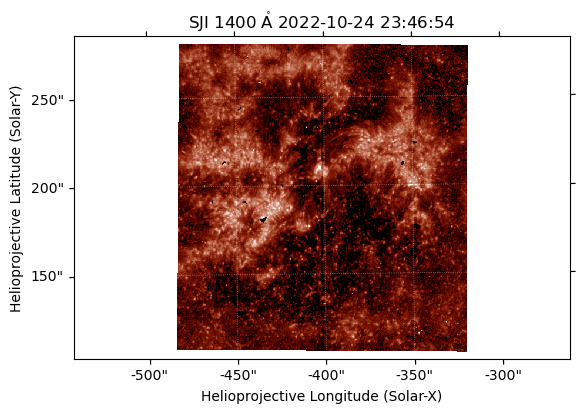

In [13]:
iris_1400_sji_2322_map = read_iris_sji("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_SJI_1400_t000.fits",
                                        index=SiIV_1393_int_map.date,sdo_rsun=True)
iris_1400_sji_2322_map.plot_settings["cmap"] = "irissji1400"
iris_1400_sji_2322_map.plot_settings["norm"] = ImageNormalize(vmin=10,vmax=200,stretch=AsinhStretch(0.05))
iris_1400_sji_2322_map.plot()

In [14]:
SunBlinker(SiIV_1393_int_map, iris_1400_sji_2322_map, reproject=True)

In [15]:
SiIV_1393_int_map.save("../../src/IRIS/20221024/2322/fit_res/SiIV_1393_int_map.fits",overwrite=True)
SiIV_1393_vel_map.save("../../src/IRIS/20221024/2322/fit_res/SiIV_1393_vel_map.fits",overwrite=True)
SiIV_1393_vel_map_no_mask = sunpy.map.Map(SiIV_1393_vel_map.data, SiIV_1393_vel_map.meta)
SiIV_1393_vel_map_no_mask.save("../../src/IRIS/20221024/2322/fit_res/SiIV_1393_vel_map_no_mask.fits",overwrite=True)

In [19]:
CII_fitres_file = readsav("../../src/IRIS/20221024/2322/fit_res/CII_1334_raster0.sav",verbose=True)

--------------------------------------------------
Date: Thu Feb 15 09:25:25 2024
User: yjzhu
Host: NB-RES-YINGJIE
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.8.3
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
 - 9 are of type VARIABLE
--------------------------------------------------
Available variables:
 - int [<class 'numpy.ndarray'>]
 - int_err [<class 'numpy.ndarray'>]
 - vel [<class 'numpy.ndarray'>]
 - vel_err [<class 'numpy.ndarray'>]
 - wid [<class 'numpy.ndarray'>]
 - wid_err [<class 'numpy.ndarray'>]
 - chi2 [<class 'numpy.ndarray'>]
 - refwvl [<class 'numpy.ndarray'>]
 - wave_corr_fuv [<class 'numpy.ndarray'>]
--------------------------------------------------


In [20]:
CII_1334_mask = (np.abs(CII_fitres_file["wid_err"]/CII_fitres_file["wid"]) > 0.5) | \
                (CII_fitres_file["wid"] < 0.03) | \
                (np.abs(CII_fitres_file["int_err"]/CII_fitres_file["int"]) > 0.5) | \
                (np.abs(CII_fitres_file["vel_err"]) > 10 )

In [21]:
CII_int_map = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                    win_ext=1,data=CII_fitres_file["int"].copy())
CII_int_map.plot_settings["cmap"] = "irissji1330"
CII_int_map.plot_settings["norm"] = ImageNormalize(vmin=0,vmax=1e4,stretch=AsinhStretch(0.1))
CII_int_map.meta["rsun_ref"] = 696000000.0

CII_vel_map = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                    win_ext=1,data=CII_fitres_file["vel"] + CII_fitres_file["wave_corr_fuv"][np.newaxis,:]/1334.5323*const.c.to_value(u.km/u.s),
                    mask=CII_1334_mask)
CII_vel_map.plot_settings["cmap"] = "RdBu_r"
CII_vel_map.plot_settings["norm"] = ImageNormalize(vmin=-30,vmax=30)
CII_vel_map.meta["rsun_ref"] = 696000000.0

CII_veff = np.sqrt(CII_fitres_file["wid"]**2 - (17.03e-3)**2)/1334.532/np.sqrt(4*np.log(2))*const.c.to_value(u.km/u.s)
CII_vth2 = np.sqrt(2*const.k_B*10**4.9*u.K/const.u/12.0107).to_value(u.km/u.s)
CII_vnth = np.sqrt(CII_veff**2 - CII_vth2**2)
CII_vnth_map = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                    win_ext=1,data=CII_vnth,
                    mask=CII_1334_mask)
CII_vnth_map.plot_settings["cmap"] = cmcm.batlowK
CII_vnth_map.plot_settings["norm"] = ImageNormalize(vmin=5,vmax=30)
CII_vnth_map.meta["rsun_ref"] = 696000000.0


/tmp/ipykernel_333437/1661894826.py:16: RuntimeWarning: invalid value encountered in sqrt
  CII_vnth = np.sqrt(CII_veff**2 - CII_vth2**2)


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]


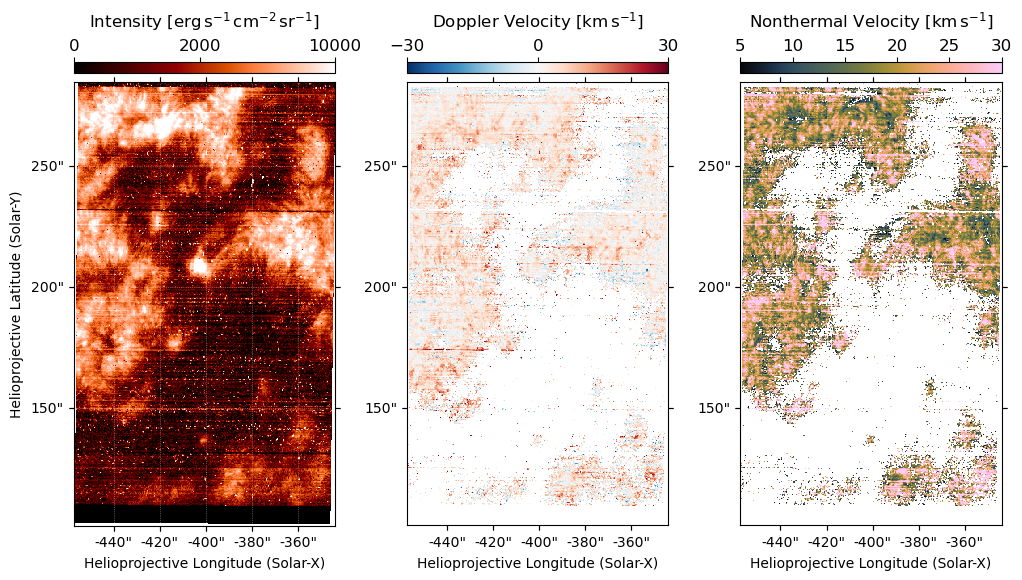

In [22]:
fig = plt.figure(figsize=(10,8),layout="constrained")

ax1 = fig.add_subplot(131,projection=CII_int_map)
im1 = CII_int_map.plot(axes=ax1)
clb1, clb_ax1 = plot_colorbar(im1,ax1,width="100%",height="8%",fontsize=12,
              bbox_to_anchor=(0,1.02,1,0.3),
              orientation="horizontal")
clb_ax1.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax1.set_xticks([0,2000,10000])
ax1.set_title(r"Intensity [$\rm erg\,s^{-1}\,cm^{-2}\,sr^{-1}$]",fontsize=12,pad=40)

ax2 = fig.add_subplot(132,projection=CII_vel_map)
im2 = CII_vel_map.plot(axes=ax2)
clb2, clb_ax2 = plot_colorbar(im2,ax2,width="100%",height="8%",fontsize=12,
              bbox_to_anchor=(0,1.02,1,0.3),
              orientation="horizontal")
clb_ax2.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax2.set_xticks([-30,0,30])
ax2.set_title(r"Doppler Velocity [$\rm km\,s^{-1}$]",fontsize=12,pad=40)

ax3 = fig.add_subplot(133,projection=CII_vnth_map)
im3 = CII_vnth_map.plot(axes=ax3)
clb3, clb_ax3 = plot_colorbar(im3,ax3,width="100%",height="8%",fontsize=12,
                bbox_to_anchor=(0,1.02,1,0.3),
                orientation="horizontal")
clb_ax3.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
# clb_ax3.set_xticks([5,10,])
ax3.set_title(r"Nonthermal Velocity [$\rm km\,s^{-1}$]",fontsize=12,pad=40)

for ax_ in (ax2,ax3):
    ax_.set_ylabel(' ')


In [23]:
CII_int_map.save("../../src/IRIS/20221024/2322/fit_res/CII_int_map.fits",overwrite=True)
CII_vel_map.save("../../src/IRIS/20221024/2322/fit_res/CII_vel_map.fits",overwrite=True)

In [24]:
MgII_fitres_file = readsav("../../src/IRIS/20221024/2322/fit_res/MgII_raster0.sav",verbose=True)

--------------------------------------------------
Date: Thu Feb 15 09:03:02 2024
User: yjzhu
Host: NB-RES-YINGJIE
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.8.3
--------------------------------------------------
Successfully read 7 records of which:
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
 - 4 are of type VARIABLE
--------------------------------------------------
Available variables:
 - lc [<class 'numpy.ndarray'>]
 - rp [<class 'numpy.ndarray'>]
 - bp [<class 'numpy.ndarray'>]
 - wave_corr_nuv [<class 'numpy.ndarray'>]
--------------------------------------------------


In [25]:
MgII_k_mask = None
MgII_h_mask = None

In [26]:
MgII_k_lc_int_map = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                    win_ext=6,data=MgII_fitres_file["lc"][:,:,1,0].T)

MgII_k_lc_int_map.plot_settings["cmap"] = "irissji2796"
MgII_k_lc_int_map.plot_settings["norm"] = ImageNormalize(vmin=0,vmax=2e3,stretch=AsinhStretch(0.1))
MgII_k_lc_int_map.meta["rsun_ref"] = 696000000.0

In [28]:

MgII_k_lc_vel_map = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                    win_ext=6,data=MgII_fitres_file["lc"][:,:,0,0].T + MgII_fitres_file["wave_corr_nuv"][np.newaxis,:]/2796.351*const.c.to_value(u.km/u.s),
                    mask=MgII_k_mask)
MgII_k_lc_vel_map.plot_settings["cmap"] = "RdBu_r"
MgII_k_lc_vel_map.plot_settings["norm"] = ImageNormalize(vmin=-15,vmax=15)
MgII_k_lc_vel_map.meta["rsun_ref"] = 696000000.0

MgII_k_bp_int_map = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                    win_ext=6,data=MgII_fitres_file["bp"][:,:,1,0].T)
MgII_k_bp_int_map.plot_settings["cmap"] = "irissji2796"
MgII_k_bp_int_map.plot_settings["norm"] = ImageNormalize(vmin=0,vmax=2e3,stretch=AsinhStretch(0.1))
MgII_k_bp_int_map.meta["rsun_ref"] = 696000000.0

MgII_k_bp_vel_map = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                    win_ext=6,data=MgII_fitres_file["bp"][:,:,0,0].T + MgII_fitres_file["wave_corr_nuv"][np.newaxis,:]/2796.351*const.c.to_value(u.km/u.s),
                    mask=MgII_k_mask)
MgII_k_bp_vel_map.plot_settings["cmap"] = "RdBu_r"
MgII_k_bp_vel_map.plot_settings["norm"] = ImageNormalize(vmin=-30,vmax=0)
MgII_k_bp_vel_map.meta["rsun_ref"] = 696000000.0

MgII_k_rp_int_map = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                    win_ext=6,data=MgII_fitres_file["rp"][:,:,1,0].T)
MgII_k_rp_int_map.plot_settings["cmap"] = "irissji2796"
MgII_k_rp_int_map.plot_settings["norm"] = ImageNormalize(vmin=0,vmax=2e3,stretch=AsinhStretch(0.1))
MgII_k_rp_int_map.meta["rsun_ref"] = 696000000.0

MgII_k_rp_vel_map = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                    win_ext=6,data=MgII_fitres_file["rp"][:,:,0,0].T + MgII_fitres_file["wave_corr_nuv"][np.newaxis,:]/2796.351*const.c.to_value(u.km/u.s),
                    mask=MgII_k_mask)
MgII_k_rp_vel_map.plot_settings["cmap"] = "RdBu_r"
MgII_k_rp_vel_map.plot_settings["norm"] = ImageNormalize(vmin=0,vmax=30)
MgII_k_rp_vel_map.meta["rsun_ref"] = 696000000.0

MgII_k_k2_ratio_map = sunpy.map.Map((MgII_k_bp_int_map.data - MgII_k_rp_int_map.data)/(MgII_k_bp_int_map.data + MgII_k_rp_int_map.data),
                                    MgII_k_bp_int_map.meta,mask=MgII_k_mask)
MgII_k_k2_ratio_map.plot_settings["cmap"] = cmcm.bam
MgII_k_k2_ratio_map.plot_settings["norm"] = ImageNormalize(vmin=-1,vmax=1,stretch=LinearStretch(slope=0.5, intercept=0.5) + AsinhStretch(0.3) + \
    LinearStretch(slope=2, intercept=-1))
MgII_k_k2_ratio_map.meta["rsun_ref"] = 696000000.0

MgII_k_k2_sep_map = sunpy.map.Map(MgII_k_rp_vel_map.data - MgII_k_bp_vel_map.data,
                                MgII_k_rp_vel_map.meta,mask=MgII_k_mask)
MgII_k_k2_sep_map.plot_settings["cmap"] = cmcm.davos
MgII_k_k2_sep_map.plot_settings["norm"] = ImageNormalize(vmin=5,vmax=45)
MgII_k_k2_sep_map.meta["rsun_ref"] = 696000000.0


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]


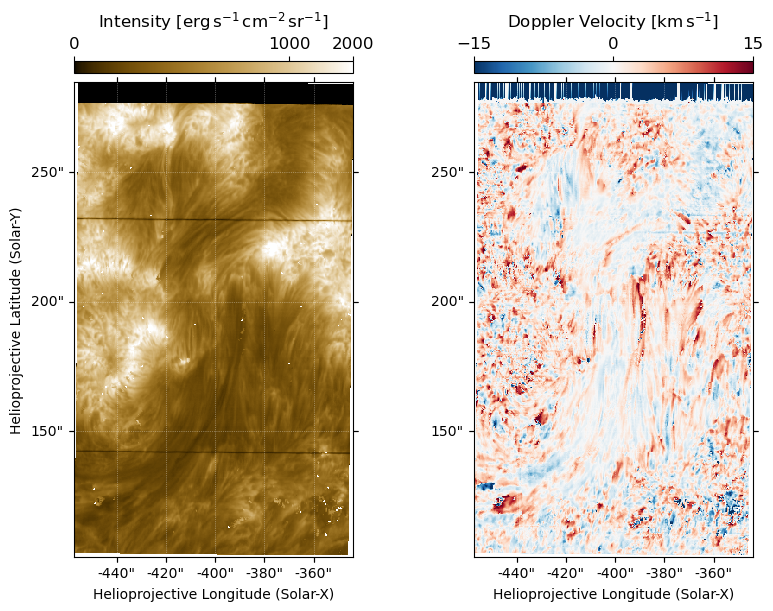

In [29]:
fig = plt.figure(figsize=(8,6),layout="constrained")

ax1 = fig.add_subplot(121,projection=MgII_k_lc_int_map)
im1 = MgII_k_lc_int_map.plot(axes=ax1)
clb1, clb_ax1 = plot_colorbar(im1,ax1,width="100%",height="8%",fontsize=12,
              bbox_to_anchor=(0,1.02,1,0.3),
              orientation="horizontal")
clb_ax1.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax1.set_xticks([0,1000,2000])
ax1.set_title(r"Intensity [$\rm erg\,s^{-1}\,cm^{-2}\,sr^{-1}$]",fontsize=12,pad=40)

ax2 = fig.add_subplot(122,projection=MgII_k_lc_vel_map)
im2 = MgII_k_lc_vel_map.plot(axes=ax2)
clb2, clb_ax2 = plot_colorbar(im2,ax2,width="100%",height="8%",fontsize=12,
              bbox_to_anchor=(0,1.02,1,0.3),
              orientation="horizontal")
clb_ax2.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax2.set_xticks([-15,0,15])
ax2.set_title(r"Doppler Velocity [$\rm km\,s^{-1}$]",fontsize=12,pad=40)

ax2.set_ylabel(' ')

In [30]:
MgII_k_lc_int_map.save("../../src/IRIS/20221024/2322/fit_res/MgII_k_lc_int_map.fits",overwrite=True)
MgII_k_lc_vel_map.save("../../src/IRIS/20221024/2322/fit_res/MgII_k_lc_vel_map.fits",overwrite=True)

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]


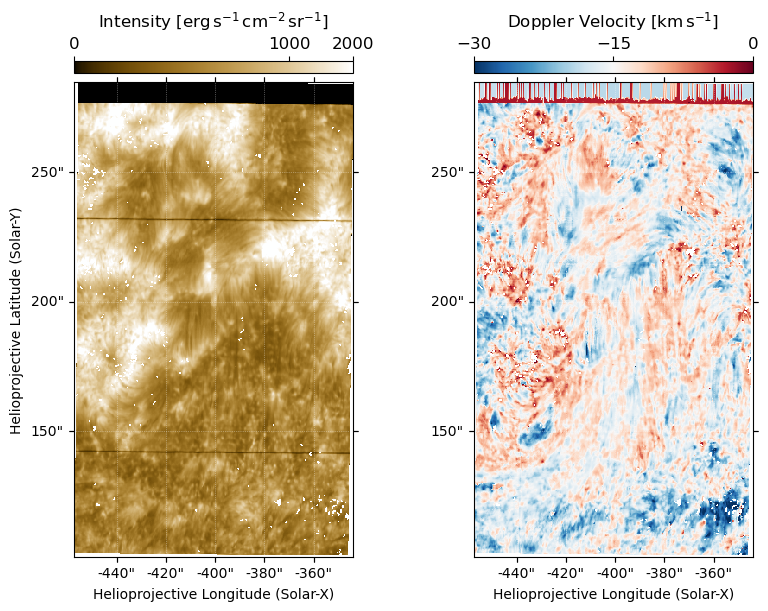

In [31]:
fig = plt.figure(figsize=(8,6),layout="constrained")

ax1 = fig.add_subplot(121,projection=MgII_k_bp_int_map)
im1 = MgII_k_bp_int_map.plot(axes=ax1)
clb1, clb_ax1 = plot_colorbar(im1,ax1,width="100%",height="8%",fontsize=12,
              bbox_to_anchor=(0,1.02,1,0.3),
              orientation="horizontal")
clb_ax1.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax1.set_xticks([0,1000,2000])
ax1.set_title(r"Intensity [$\rm erg\,s^{-1}\,cm^{-2}\,sr^{-1}$]",fontsize=12,pad=40)

ax2 = fig.add_subplot(122,projection=MgII_k_bp_vel_map)
im2 = MgII_k_bp_vel_map.plot(axes=ax2)
clb2, clb_ax2 = plot_colorbar(im2,ax2,width="100%",height="8%",fontsize=12,
              bbox_to_anchor=(0,1.02,1,0.3),
              orientation="horizontal")
clb_ax2.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax2.set_xticks([-30,-15,0])
ax2.set_title(r"Doppler Velocity [$\rm km\,s^{-1}$]",fontsize=12,pad=40)

ax2.set_ylabel(' ')

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]


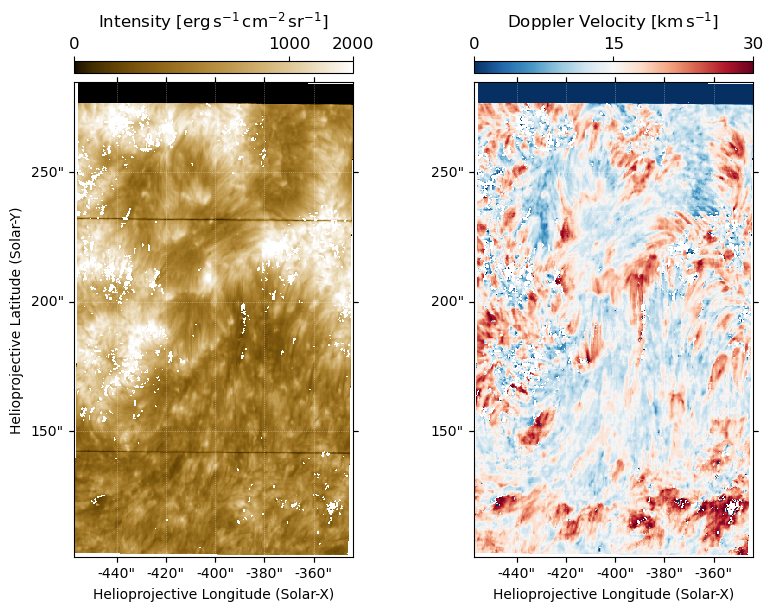

In [32]:
fig = plt.figure(figsize=(8,6),layout="constrained")

ax1 = fig.add_subplot(121,projection=MgII_k_rp_int_map)
im1 = MgII_k_rp_int_map.plot(axes=ax1)
clb1, clb_ax1 = plot_colorbar(im1,ax1,width="100%",height="8%",fontsize=12,
              bbox_to_anchor=(0,1.02,1,0.3),
              orientation="horizontal")
clb_ax1.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax1.set_xticks([0,1000,2000])
ax1.set_title(r"Intensity [$\rm erg\,s^{-1}\,cm^{-2}\,sr^{-1}$]",fontsize=12,pad=40)

ax2 = fig.add_subplot(122,projection=MgII_k_rp_vel_map)
im2 = MgII_k_rp_vel_map.plot(axes=ax2)
clb2, clb_ax2 = plot_colorbar(im2,ax2,width="100%",height="8%",fontsize=12,
              bbox_to_anchor=(0,1.02,1,0.3),
              orientation="horizontal")
clb_ax2.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax2.set_xticks([0,15,30])
ax2.set_title(r"Doppler Velocity [$\rm km\,s^{-1}$]",fontsize=12,pad=40)

ax2.set_ylabel(' ')

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]


Text(0.5, 1.0, '$v_{\\rm k2r} - v_{\\rm k2v}\\ [{\\rm km\\,s^{-1}}]$')

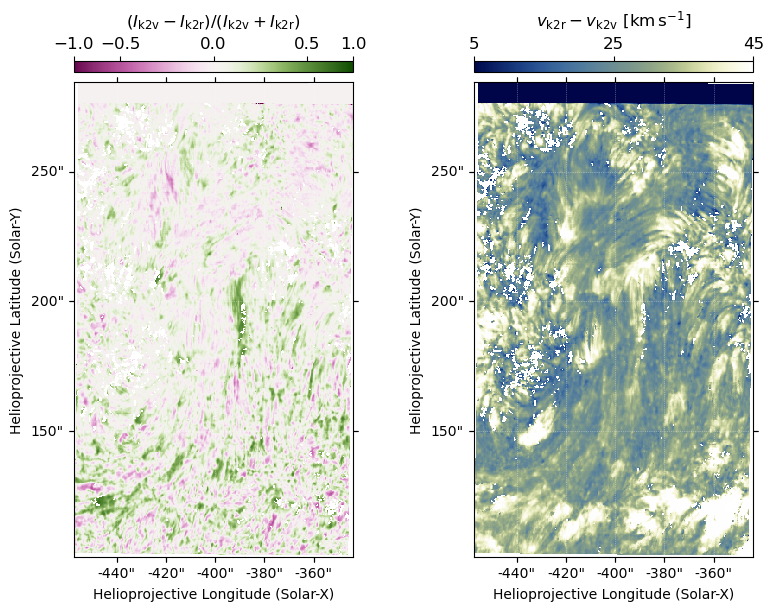

In [33]:
fig = plt.figure(figsize=(8,6),layout="constrained")

ax1 = fig.add_subplot(121,projection=MgII_k_k2_ratio_map)
im1 = MgII_k_k2_ratio_map.plot(axes=ax1)
clb1, clb_ax1 = plot_colorbar(im1,ax1,width="100%",height="8%",fontsize=12,
              bbox_to_anchor=(0,1.02,1,0.3),
              orientation="horizontal")
clb_ax1.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax1.set_xticks([-1,-0.5,0,0.5,1])
ax1.set_title(r"$(I_{\rm k2v} - I_{\rm k2r})/(I_{\rm k2v} + I_{\rm k2r})$",fontsize=12,pad=40)

ax2 = fig.add_subplot(122,projection=MgII_k_k2_sep_map)
im2 = MgII_k_k2_sep_map.plot(axes=ax2)
clb2, clb_ax2 = plot_colorbar(im2,ax2,width="100%",height="8%",fontsize=12,
              bbox_to_anchor=(0,1.02,1,0.3),
              orientation="horizontal")
clb_ax2.tick_params(top=True,labeltop=True,labelbottom=False,bottom=False,labelsize=12)
clb_ax2.set_xticks([5,25,45])
ax2.set_title(r"$v_{\rm k2r} - v_{\rm k2v}\ [{\rm km\,s^{-1}}]$",fontsize=12,pad=40)

In [34]:
MgII_k_k2_ratio_map.save("../../src/IRIS/20221024/2322/fit_res/MgII_k_k2_ratio_map.fits",overwrite=True)
MgII_k_k2_sep_map.save("../../src/IRIS/20221024/2322/fit_res/MgII_k_k2_sep_map.fits",overwrite=True)